# 2D Fast Accurate Fourier Transform
## Complex to Complex

In [1]:
import numpy as np
import ctypes
from ctypes import *

import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math


In [2]:
%matplotlib inline    


## Loading FFT routines

In [3]:
gridDIM = 64

size = gridDIM*gridDIM

axes0 = 0
axes1 = 1

segment_axes0 = 0
segment_axes1 = 0

normFactor = 0.0

DIR_BASE = "/home/robert/Documents/new1/FFT/code/FAFT-7/FAFT/FAFT128_C2C-master/"

# FAFT 
_faft128_2D = ctypes.cdll.LoadLibrary( DIR_BASE+'FAFT128_2D_C2C.so' )
_faft128_2D.FAFT128_2D_C2C.restype = int
_faft128_2D.FAFT128_2D_C2C.argtypes = [ctypes.c_void_p, 
                                         ctypes.c_float, ctypes.c_float, ctypes.c_int, 
                                         ctypes.c_int, ctypes.c_float]

cuda_faft = _faft128_2D.FAFT128_2D_C2C

In [4]:
def Gaussian(x,mu,sigma):
    return np.exp( - (x-mu)**2/sigma**2/2. , dtype=np.float32 )/(sigma*np.sqrt( 2*np.pi  ))

def fftGaussian(p,mu,sigma):
    return np.exp(-1j*mu*p , dtype=np.float32 )*np.exp( - p**2*sigma**2/2. , dtype=np.float32 )

## Initializing Data

## Gaussian

 Amplitude x =  7.0
 Amplitude p =  5.0
        
mu_x =  1.5
mu_y =  1.5
sigma_x =  1.0
sigma_y =  1.0
   
n     =  64
dx    =  0.21875
dp    =  0.15625
           standard fft dp =  0.448798950513      
    
delta =  0.00543986621896
    
The Gaussian extends to the numerical error in single precision:
    min =  (6.66874e-33+0j)


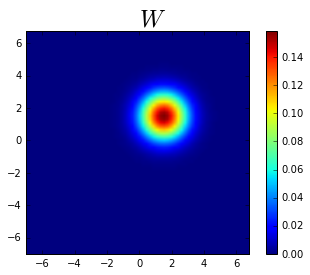

In [6]:
# Gaussian parameters
mu_x = 1.5
sigma_x = 1.

mu_y = 1.5
sigma_y = 1.

# Grid parameters
x_amplitude = 7.
p_amplitude = 5.                # With the traditional method p amplitude is fixed to: 2 * np.pi /( 2*x_amplitude ) 

dx = 2*x_amplitude/float(gridDIM)  # This is dx in Bailey's paper
dp = 2*p_amplitude/float(gridDIM)  # This is gamma in Bailey's paper

delta = dx*dp/(2*np.pi)

x_range = np.linspace( -x_amplitude, x_amplitude-dx, gridDIM) 
p_range = np.linspace( -p_amplitude, p_amplitude-dp, gridDIM) 

x = x_range[ np.newaxis, : ] 
y = x_range[ :, np.newaxis ] 

f =  Gaussian(x,mu_x,sigma_x)*Gaussian(y,mu_y,sigma_y)
f = f + 1j*np.zeros_like(f)

plt.imshow( f.real, extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] , origin='lower')

axis_font = {'size':'24'}
plt.text( 0., 7.1, '$W$' , **axis_font)
plt.colorbar()

print ' Amplitude x = ',x_amplitude
print ' Amplitude p = ',p_amplitude
print '        '

print 'mu_x = ', mu_x
print 'mu_y = ', mu_y
print 'sigma_x = ', sigma_x
print 'sigma_y = ', sigma_y
print '   '

print 'n     = ', x.size
print 'dx    = ', dx
print 'dp    = ', dp
print '           standard fft dp = ',2 * np.pi /( 2*x_amplitude ) , '     '
print '    '
print 'delta = ', delta


print '    '

print 'The Gaussian extends to the numerical error in single precision:'  
print '    min = ', np.min(f)


## $W$ TRANSFORM

In [7]:
F_gpu = gpuarray.zeros( ( gridDIM, gridDIM ), dtype=np.complex64 )

F_gpu[:,:] = f[:,:]

### Forward Transform

In [8]:
# Executing FFT

cuda_faft( int(F_gpu.gpudata), dx, delta, segment_axes0, axes0, normFactor )
cuda_faft( int(F_gpu.gpudata), dx, delta, segment_axes1, axes1, normFactor )


1

(-5.0, 4.84375)

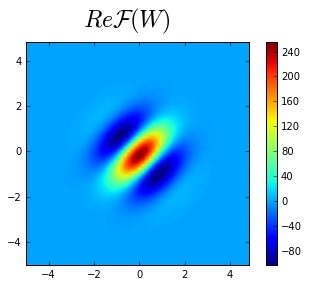

In [9]:
plt.imshow( F_gpu.get().real/float(np.sqrt(size))  ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Re \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude-dp)
plt.ylim(-p_amplitude , p_amplitude-dp)

(-5.0, 4.84375)

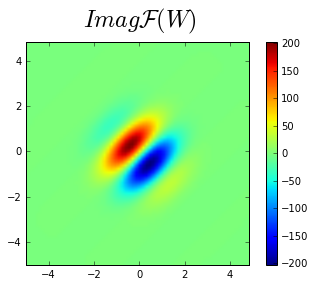

In [10]:
plt.imshow( F_gpu.get().imag/float(np.sqrt(size)) ,
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text(-p_amplitude/2. , 1.1*p_amplitude, '$Imag \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude-dp)
plt.ylim(-p_amplitude , p_amplitude-dp)

### Inverse Transform

In [11]:
# Executing iFFT

cuda_faft( int(F_gpu.gpudata), dx, -delta, segment_axes0, axes0, normFactor )
cuda_faft( int(F_gpu.gpudata), dx, -delta, segment_axes1, axes1, normFactor )

1

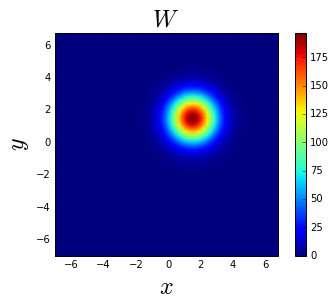

In [12]:
plt.imshow( F_gpu.get().real/(float(size*size))  ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude, x_amplitude-dx], origin='lower' )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 7.2, '$W$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)

plt.xlabel('$x$',**axis_font)
plt.ylabel('$y$',**axis_font)